In [1]:
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy
import sklearn
import shutil
import tensorflow as tf

from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
#from scipy.spatial.distance import mahalanobis # Not vectorized and terribly slow!
from six.moves import xrange  # pylint: disable=redefined-builtin
from sklearn import mixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from tensorflow.examples.tutorials.mnist import input_data

pj = os.path.join

%matplotlib inline

In [2]:
if os.name == "nt":
    LOG_DIR = "tf_graphs/cifar10_2"
    DATA_DIR = "J:/MLDataSets/Cifar10/cifar-10-batches-bin"
else:
    raise RuntimeError("Don't have linux paths atm")

file_ct = 0

In [3]:
g_image_size = 32
g_num_chans = 3
g_color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b']
g_class_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

In [4]:
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.array(x_train, dtype=float) / 256.
x_test = np.array(x_test, dtype=float) / 256.

Using TensorFlow backend.


In [5]:
y_train[5]

array([1], dtype=uint8)

In [6]:
conf = {}
conf["batch_size"] = 512
conf["fc_bottleneck"] = False
conf["use_tutorial"] = False
conf["do_classify"] = True

conf["regularize"] = False
conf["num_epochs"] = 1500
conf["lambda"] = 0.1
conf["lr"] = 0.001
conf["momentum"] = 0.9

In [7]:
conf["numh"] = 8
conf["num_filts1"] = 128
conf["num_filts2"] = 64
conf["num_filts3"] = 32
conf["stride"] = 2
conf["pool_size"] = 2

#The size of the filters, *not* the size of the convolution kernel
conf["filt_size1"] = 3
conf["filt_size2"] = 3
conf["filt_size3"] = 3

conf["upsamp_sz1"] = 7
conf["upsamp_sz2"] = 14
conf["upsamp_sz3"] = g_image_size

print("Number of samples: " + str(g_image_size))
print("Filt size 1: " + str(conf["filt_size1"]))
print("Filt size 2: " + str(conf["filt_size2"]))
print("Filt size 3: " + str(conf["filt_size3"]))

Number of samples: 32
Filt size 1: 3
Filt size 2: 3
Filt size 3: 3


In [8]:
tf.reset_default_graph()

In [9]:
x = tf.placeholder(tf.float32, shape=(None, g_image_size, g_image_size, g_num_chans), name="x")

In [10]:
def make_conv_layer(t_in, filt_sz, stride, pool_sz, num_filts, name):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        filt_shape = [filt_sz, filt_sz, int(t_in.shape[3]), num_filts]
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())
        #tf.layers.conv2d uses the glorot_uniform_initializer
        
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
        y = tf.nn.conv2d(t_in,
                         W,
                         [1, 1, 1, 1],
                         padding="SAME") + b
        mp = tf.layers.max_pooling2d(y,
                                    pool_sz,
                                    strides=stride,
                                    padding="SAME",
                                    name=name+"_mp")
        act = tf.nn.relu(mp, name=name+"_relu")

        tf.summary.histogram(act.name, act)
        print("act: ", act.shape)
        
        return act   

In [11]:
def make_deconv_layer(t_in, upsamp_sz, num_filts, name, use_relu=True):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        upsample = tf.image.resize_nearest_neighbor(t_in, (upsamp_sz, upsamp_sz))
        
        filt_shape = [int(t_in.shape[1]), int(t_in.shape[2]), int(t_in.shape[3]), num_filts]
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())        
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
    
        deconv = tf.nn.conv2d(upsample, 
                              W, 
                              [1, 1, 1, 1],
                              "SAME") + b
        print("deconv: ", deconv.shape)

        if use_relu:
            act = tf.nn.relu(deconv, name=name+"_relu")
        else:
            act = deconv
            
        tf.summary.histogram(act.name, act)
        print(act.shape)
        
        return act

In [12]:
def make_fc_layer(t_in, fan_out, name):
    assert(len(t_in.shape)==2)
    with tf.name_scope(name):
        W = tf.Variable(tf.random_normal([int(t_in.shape[1]), fan_out], stddev=1), name=name+"_W")
        b = tf.Variable(tf.random_normal([fan_out], stddev=1), name=name+"_b")
        y = tf.matmul(t_in, W) + b
        act = tf.nn.sigmoid(y, name=name+"_sigmoid")
        tf.summary.histogram(act.name, act)
        return act

In [13]:
def plot_confusion_matrix(cls_pred):
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=target,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [14]:
conv1 = make_conv_layer(x, conf["filt_size1"], conf["stride"], conf["pool_size"], conf["num_filts1"], "conv1")
conv2 = make_conv_layer(conv1, conf["filt_size2"], conf["stride"], conf["pool_size"], conf["num_filts2"], "conv2")
conv3 = make_conv_layer(conv2, conf["filt_size3"], conf["stride"], conf["pool_size"], conf["num_filts3"], "conv3")

INFO:tensorflow:Summary name conv1/conv1_relu:0 is illegal; using conv1/conv1_relu_0 instead.
act:  (?, 16, 16, 128)
INFO:tensorflow:Summary name conv2/conv2_relu:0 is illegal; using conv2/conv2_relu_0 instead.
act:  (?, 8, 8, 64)
INFO:tensorflow:Summary name conv3/conv3_relu:0 is illegal; using conv3/conv3_relu_0 instead.
act:  (?, 4, 4, 32)


In [15]:
if conf["do_classify"]:
    num_flat = int(conv3.shape[1]) * int(conv3.shape[2]) * int(conv3.shape[3])
    fc1 = make_fc_layer( tf.reshape(conv3, [-1, num_flat]), 64, "fc1")
    fc2 = make_fc_layer( fc1, 32, "fc2")
else:
    if conf["fc_bottleneck"]:
        fc_start0 = make_conv_layer(conv3, 2, 2, 2, conf["num_filts3"], "fc_start0")
        fc_start = tf.squeeze( make_conv_layer(fc_start0, 2, 2, 2, conf["num_filts3"], "conv_bottle"), [1, 2])

        hc = make_fc_layer(fc_start, conf["numh"], "hc")
        deconv_start0 = make_deconv_layer(tf.reshape(hc,[-1, 1, 1, int(hc.shape[1])]), 2, conf["num_filts3"], "deconv_start0")
        deconv_start = make_deconv_layer(deconv_start0, 2, conf["num_filts3"], "deconv_bottle")
    else:
        deconv_start = conv3

INFO:tensorflow:Summary name fc1/fc1_sigmoid:0 is illegal; using fc1/fc1_sigmoid_0 instead.
INFO:tensorflow:Summary name fc2/fc2_sigmoid:0 is illegal; using fc2/fc2_sigmoid_0 instead.


In [16]:
if conf["do_classify"]:
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    out = tf.nn.softmax( make_fc_layer(fc2, 10, "out_class") )
    
    target = tf.squeeze( tf.one_hot(y, 10) )
else:
    target = x

INFO:tensorflow:Summary name out_class/out_class_sigmoid:0 is illegal; using out_class/out_class_sigmoid_0 instead.


In [17]:
if not conf["do_classify"]:
    deconv1 = make_deconv_layer(deconv_start, conf["upsamp_sz1"], conf["num_filts3"], "deconv1")
    deconv2 = make_deconv_layer(deconv1, conf["upsamp_sz2"], conf["num_filts2"], "deconv2")
    deconv3 = make_deconv_layer(deconv2, conf["upsamp_sz3"], conf["num_filts1"], "deconv3")

In [18]:
if not conf["do_classify"]:
    out = tf.layers.conv2d(deconv3, 
                           g_num_chans, 
                           (conf["filt_size1"], conf["filt_size1"]),
                           padding='same',
                           activation=None)
    print("out: ", out.shape)
    
    decoded = tf.nn.sigmoid(out, name='decoded')

In [19]:
with tf.name_scope("conv_mse"):
    if conf["do_classify"]:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=out)
        cost = tf.reduce_mean(loss)
        
        pick = tf.cast( tf.argmax(out, axis=1), tf.int32 )
        accuracy = tf.reduce_mean( tf.cast(tf.equal(pick, y), tf.float32), name="accuracy" )
    else:
        sq_error = tf.reduce_mean(np.square(out - target), axis=1)
        cost = tf.reduce_mean( sq_error, name="cost" )
        accuracy = None

    tf.summary.scalar("cost", cost)
    tf.summary.scalar("accuracy", accuracy)

        
with tf.name_scope("conv_opt"):
    optimizer = tf.train.AdamOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.RMSPropOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.MomentumOptimizer(learning_rate=conf["lr"], momentum=conf["momentum"])
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf["lr"])
    training_op = optimizer.minimize(cost)


In [20]:
conf["num_epochs"] = 10
with tf.device("/gpu:0"):
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

    tf.summary.scalar("cost", cost)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

    dummy = np.random.rand(100,28,28,3)
    for i in range(conf["num_epochs"]):
        for ii in range(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN//conf["batch_size"]):
#            batch,labels = inputs(False, DATA_DIR, conf["batch_size"])
#            imgs = batch[0].reshape((-1, g_image_size, g_image_size, 3))
            batch_x = x_train[(ii*conf["batch_size"]):((ii+1)*conf["batch_size"]),:,:,:]
            batch_y = y_train[(ii*conf["batch_size"]):((ii+1)*conf["batch_size"])]
            summary,_ = sess.run([merged, training_op], feed_dict={x : batch_x, y : batch_y})
            train_writer.add_summary(summary, i*(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN//conf["batch_size"])+ii)
            if ii%100 == 0:
                cost_ii = cost.eval(session=sess, feed_dict={x : batch_x, y : batch_y})
                accuracy_ii = accuracy.eval(session=sess, feed_dict={x : batch_x, y : batch_y})
                print("Cost: %f, accuracy: %f" % (cost_ii, accuracy_ii))

Cost: 0.734247, accuracy: 0.122360
Cost: 0.731629, accuracy: 0.103760
Cost: 0.730690, accuracy: 0.102783


KeyboardInterrupt: 

In [314]:
idx = 102
out.eval(session=sess, feed_dict={x : np.reshape(x_train[idx,:,:,:], [-1,32,32,3]), y : y_train[idx]})
m = tf.argmax(out, axis=1).eval(session=sess, feed_dict={x : np.reshape(x_train[idx,:,:,:], [-1,32,32,3]), y : y_train[idx]})
t = y.eval(session=sess, feed_dict={x : np.reshape(x_train[idx,:,:,:], [-1,32,32,3]), y : y_train[idx]})
print(m[0] ,t[0])
m==t
len(x_test)

9 9


NameError: name 'NUM_EXAMPLES_PER_EPOCH_FOR_TEST' is not defined

In [333]:
if conf["do_classify"]:
    num_test = (len(x_test) // conf["batch_size"]) * conf["batch_size"]
    y_true = -1 * np.ones((num_test))
    y_pred = -1 * np.ones((num_test))
    for i in range(len(x_test) // conf["batch_size"]):
        idx_start = int( i*conf["batch_size"] )
        idx_end = int( (i+1)*conf["batch_size"] )
        batch_x = x_test[idx_start:idx_end,:,:,:]
        batch_y = y_test[idx_start:idx_end]
        y_eval = y.eval(session=sess, feed_dict={x : batch_x, y : batch_y})
        pick_eval = pick.eval(session=sess, feed_dict={x : batch_x, y : batch_y})
        y_true[idx_start:idx_end] = y_eval.reshape((conf["batch_size"]))
        y_pred[idx_start:idx_end] = pick_eval
        
    cm = confusion_matrix(y_true=y_true,  # True class for test-set.
                          y_pred=y_pred)  # Predicted class.
    
    for i in range(len(cm)):
        # Append the class-name to each line.
        acc_i = cm[i,i] / np.sum(cm[i,:])
        class_name = "({}) {}, {}%".format(i, g_class_names[i], acc_i)
        print(cm[i, :], class_name)

[655  29  37  29   9  19  11  15 124  38] (0) airplane, 0.6780538302277432%
[ 40 713   2  19   2   1  11   7  51 125] (1) automobile, 0.7342945417095778%
[110  13 371  68  96 128  94  37  31  21] (2) bird, 0.3828689370485036%
[ 17  11  43 475  51 190  93  36  33  27] (3) cat, 0.48668032786885246%
[ 42   6  55  84 506  48 108  95  26   4] (4) deer, 0.5195071868583162%
[  7   6  45 287  37 467  23  67  20  13] (5) dog, 0.48045267489711935%
[  6   9  23  96  45  18 757   9  11   7] (6) frog, 0.7716615698267074%
[ 22   7  21  82  47  86  11 671   9  17] (7) horse, 0.6896197327852004%
[ 86  41   3  23   1  10   9   7 766  24] (8) ship, 0.7896907216494845%
[ 40 176   8  21   1   6  14  24  53 633] (9) truck, 0.6485655737704918%


ValueError: total size of new array must be unchanged

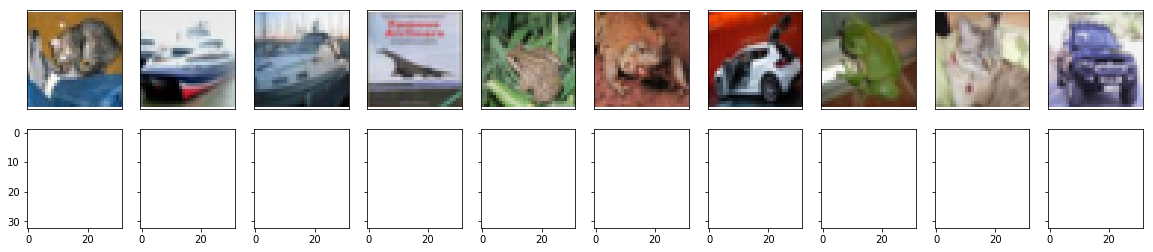

In [311]:
for i in range(5):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    in_imgs = x_test[10*i:10*(i+1)]
    reconstructed = out.eval(session=sess, feed_dict={x: in_imgs.reshape((10, g_image_size, g_image_size, 3))})

    for images, row in zip([in_imgs, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((g_image_size, g_image_size, 3)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


    fig.tight_layout(pad=0.1)